In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.patches as mpatches
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist, squareform

In [3]:
class LabelPropagationGraph:
    def __init__(self, edge_data, directed):
        self.edge_data = edge_data
        self.directed = directed  # Fix: define this before build_adj
        self.adj_matrix = self.build_adj(edge_data)
        self.labels = None
        self.iterations = 0

    def build_adj(self, data):
        vertices = np.max(data)
        adj = np.zeros((vertices + 1, vertices + 1))
        for i in range(len(data)):
            a, b = int(data[i, 0]), int(data[i, 1])
            adj[a, b] = 1
            if self.directed is False:
                adj[b, a] = 1
        return adj

    def run_label_propagation(self, max_iter=100):
        n = len(self.adj_matrix)
        self.labels = np.arange(n)
        self.iterations = 0

        while True:
            updated = False
            for i in range(n):
                neighbors = np.where(self.adj_matrix[i] == 1)[0]
                if len(neighbors) == 0:
                    continue
                neighbor_labels = self.labels[neighbors]
                unique_labels, counts = np.unique(neighbor_labels, return_counts=True)
                max_labels = unique_labels[counts == counts.max()]
                chosen_label = np.random.choice(max_labels)
                if self.labels[i] != chosen_label:
                    self.labels[i] = chosen_label
                    updated = True
            self.iterations += 1
            if not updated or self.iterations > max_iter:
                break
        return self.labels, self.iterations

    def plot(self):
        if self.labels is None:
            raise ValueError("Run label propagation before plotting.")
        graph = nx.Graph(self.adj_matrix)
        unique_clusters = np.unique(self.labels)
        cmap = plt.cm.Set3
        colors = cmap(np.linspace(0, 1, len(unique_clusters)))
        pos = nx.spring_layout(graph, seed=42)
        node_colors = [colors[np.where(unique_clusters == label)[0][0]] for label in self.labels]
        plt.figure(figsize=(7, 5))
        nx.draw(graph, pos, node_color=node_colors, with_labels=False, node_size=100, edge_color='gray')
        plt.title(f'Graph Colored by Label Propagation After {self.iterations} Iterations')
        legend_handles = [mpatches.Patch(color=colors[i], label=f'Cluster {label}')
                          for i, label in enumerate(unique_clusters)]
        plt.legend(handles=legend_handles, loc='best', title='Clusters', fontsize='small')
        plt.show()

In [7]:
df = pd.read_csv('cleaned_mlb_2022_full.csv')

# Focus on players with at least 100 PAs
df = df[df['PA'] >= 100].reset_index(drop=True)

# Select swing-related features
features = ['Swing%', 'O-Swing%']
X = df[features].dropna().copy()

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Compute pairwise distances and build graph edges
# We'll use a threshold (e.g., 0.5) to define "similar" hitters
dist_matrix = squareform(pdist(X_scaled, metric='euclidean'))

# Set similarity threshold
threshold = 0.5
edges = []
n = dist_matrix.shape[0]
for i in range(n):
    for j in range(i + 1, n):
        if dist_matrix[i, j] < threshold:
            edges.append([i, j])

edges = np.array(edges)
print(f"Number of nodes: {n}, Number of edges: {len(edges)}")


Number of nodes: 130, Number of edges: 1009


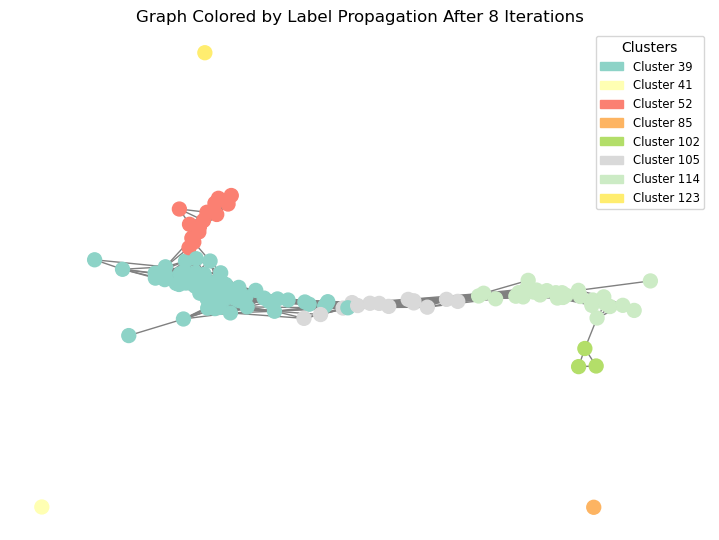

,Name,PA,Swing%,O-Swing%,Cluster
0,Aaron Judge,696,0.425,0.268,114
1,Nolan Arenado,620,0.484,0.361,39
2,Manny Machado,644,0.508,0.342,39
3,Jose Altuve,604,0.438,0.314,105
4,Paul Goldschmidt,651,0.417,0.276,114


In [9]:
# Apply label propagation algorithm to the swing-style graph
graph = LabelPropagationGraph(edges, directed=False)
labels, iterations = graph.run_label_propagation()
graph.plot()

# Store cluster labels in the original dataframe
df_swing = df.iloc[:len(labels)].copy()
df_swing['Cluster'] = labels

# Preview data with cluster assignments
df_swing[['Name', 'PA', 'Swing%', 'O-Swing%', 'Cluster']].head()


This network visualization shows clusters formed through label propagation based on hitters’ similarity in Swing% and O-Swing% metrics. Each node represents a hitter, and edges connect players with comparable swing tendencies. The clusters are clearly color-coded and labeled, allowing quick identification of communities. Notably, some clusters are denser and more interconnected, while others like Cluster 123 and 85 are isolated, suggesting players with outlier swing behaviors. This summary table displays five high-profile hitters with their plate appearances (PA), Swing%, O-Swing%, and assigned cluster labels. Aaron Judge and Nolan Areando fall into different clusters (114 and 39), highlighting how even elite players can differ in swing discipline. This table serves as a useful tool to interpret cluster assignments in terms of real-world player identity and playing style.

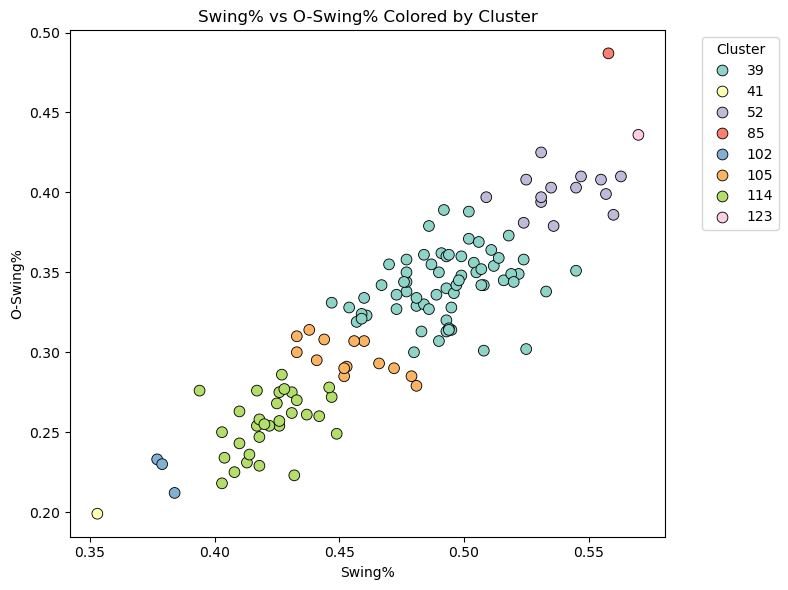

In [15]:
# Scatterplot of Swing% vs O-Swing% colored by cluster label
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_swing,
    x='Swing%',
    y='O-Swing%',
    hue='Cluster',
    palette='Set3',
    s=60,
    edgecolor='black'
)
plt.title('Swing% vs O-Swing% Colored by Cluster')
plt.xlabel('Swing%')
plt.ylabel('O-Swing%')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


This scatterplot plots Swing% against O-Swing% and uses cluster labels as color groups. The clusters form distinguishable bands along the diagonal, illustrating that players with similar overall aggressiveness (Swing%) often share similar out-of-zone swing tendencies (O-Swing%). A few clusters such as 85 and 123 stand out from the central trendline, identifying extreme or outlier swing profiles.

The visualizations collectively demonstrate how label propagation effectively discovers natural communities among hitters based on their swing discipline. The network plot helps identify tightly connected behavioral groups, while the scatterplot gives insight into the directionality and spread of swing behavior across clusters. Together, the plots highlight how similar offensive traits form meaningful groupings, while also identifying strategic outliers.